# (5): Circumstellar Disk Emission Modeling and Analysis

Now that you've experimented with visibility modeling in Part (4), we're going to bring in an outside code package that performs a highly-sophisticated optimization of such models to do the hard work for us.  The package is called '${\tt frankenstein}$'.  If you like, you can read about it in [this article](https://arxiv.org/abs/2005.07709) (this is *not necessary*: it is very complicated!).  You can also read more about the package and, most importantly, how to install it, on an [associated website](https://discsim.github.io/frank/index.html).

Again, to start we load the visibility data:

In [4]:
import os, sys, time           
import numpy as np             
import matplotlib.pyplot as plt
%matplotlib inline                

# disk target name
disk_name = 'SR4'

working_dir = '/Users/William/Desktop/Undergraduate Research/'
if not os.path.exists(working_dir+disk_name+'_continuum_tbin60s_SPWavg.vis.npz'):
    dsharp_url = 'http://www.cfa.harvard.edu/~sandrews/data/'+disk_name+'_continuum_tbin60s_SPWavg.vis.npz'
    print('Downloading VISIBILITY data...')
    urllib.request.urlretrieve(dsharp_url, working_dir+disk_name+'_continuum_tbin60s_SPWavg.vis.npz')
    print('...Download complete.')

# load the visibility data
dat = np.load(disk_name+'_continuum_tbin60s_SPWavg.vis.npz')
u, v, vis, wgt = dat['u'], dat['v'], dat['Vis'], dat['Wgt']


Next, we will load the ${\tt frankenstein}$ functions, fix the emission geometry, and then run the visibility model fitting.  What this does is effectively invert the visibility profile in a way that can reconstruct an arbitrary surface brightness distribution.  The code uses a special approach that combines oscillatory behavior drawn from a [Gaussian Process](https://en.wikipedia.org/wiki/Gaussian_process) to match the observations in the Fourier domain.  The details don't really matter here, but the important point is that it really does optimize the solution.  When the emission is genuinely noise, we'll see some oscillatory behavior imprinted on the model, but this usually happens at a level that is negligible.  We can help mitigate that with some parameter choices (I've done that below).  Note that this takes 1-3 minutes!

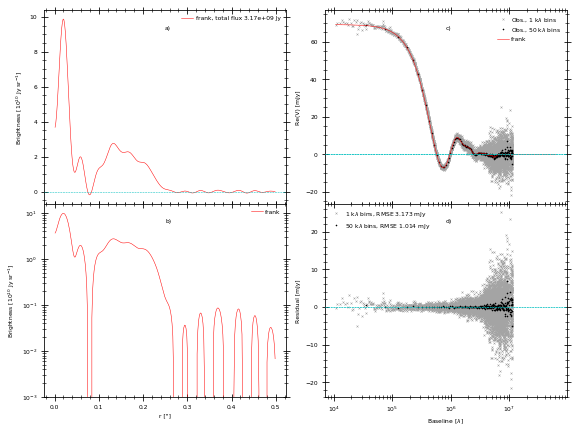

In [5]:
from frank.radial_fitters import FrankFitter
from frank.geometry import FixedGeometry
from frank.make_figs import use_frank_plotting_style, make_quick_fig
from frank.io import save_fit

# set the disk viewing geometry parameters
incl, PA = 22., 26.
offRA, offDEC = -0.060, -0.509
geom = FixedGeometry(incl, PA, dRA=offRA, dDec=offDEC)

# set the frankenstein hyper-parameters
Rmax  = 0.5    # this is ~1.5x the maximum radius where we see emission (in arcseconds)
Ncoll = 300    # this is the # of collocation points used in the model 
alpha = 1.3    # this controls how much noisy data is included in the fit   
wsmth = 0.1    # this controls how much the fit smooths over oscillations

# configure the fitting code setup
FF = FrankFitter(Rmax=Rmax, N=Ncoll, geometry=geom, alpha=alpha, weights_smooth=wsmth)

# fit the visibilities
sol = FF.fit(u, v, vis, wgt)

# save the fit
save_fit(u, v, vis, wgt, sol, prefix='SR4_continuum_frank')

# make a plot to show the outcome
fig, axes = make_quick_fig(u, v, vis, wgt, sol, bin_widths=[1e3, 5e4], force_style=True)

This plot is a bit hard to read, but that's because its just the default settings.  It shows on the left two views of the best-fit radial surface brightness profile, on a linear (top) and logarithmic (bottom) scale.  You can see on the bottom left the oscillations at the noisy parts most clearly.  We expect these not to matter for our purposes.  Note the "extra" Gaussian (or extra gap) in the emission "core" that we would've struggled to include in our model for Part (4)!  The right top panel shows the data visibilities in two binnings: 1 k$\lambda$ in gray, and 50 k$\lambda$ in black, on a log-linear scaling.  The red curve is the best-fit model (i.e., the FT of the brightness profile in the left panels).  The bottom right panel shows the residuals (data $-$ model).

Ok, so we can see from this that the modeling did a great job fitting the visibility data.  Now we want to examine the results in the image-plane.  Unfortunately, without a CfA computer account, I will have to run some setup for you.  I've already done this, so you can grab the data below and then work on the activities.

In [6]:
# first generate the model visibilities and save them: this is what you'd use to make the images
mvis = sol.predict(u, v, geometry=geom)
np.savez('SR4_frankmodel.vis.npz', u=u, v=v, Vis=mvis, Wgt=wgt)

# here you'd do the imaging...but we'll skip that

# download the data, model, and residual images (.FITS files)
import urllib.request

# set this to your project directory (or however you like)
wdir = '/Users/William/Desktop/Undergraduate Research/'

# download source
dsrc = 'http://www.cfa.harvard.edu/~sandrews/data/'

# if you don't already have the datafiles, download them
files = ['data', 'model', 'resid']
for ifile in files:
    if not os.path.exists(wdir+'SR4_'+ifile+'.fits'):
        urllib.request.urlretrieve(dsrc+'SR4_'+ifile+'.fits', wdir+'SR4_'+ifile+'.fits')

**Activities:**

- Make a plot with three panels across, showing the images for the data, model, and residuals (with the same stretch, etc., as in Part 1).
- Make a plot showing the residuals image, normalized by the estimated RMS noise level in the image (which is 25 $\mu$Jy/beam).  Use a linear stretch and a diverging color map to show positive and negative residuals clearly.  
- Make a plot with three panels down, showing the polar-projected images for the data, model, and residuals (with the same stretch, etc., as in Part 2).
- For some narrow radial range around the main gap feature, extract, average, and plot the (averaged) residuals as a function of the azimuthal angle.

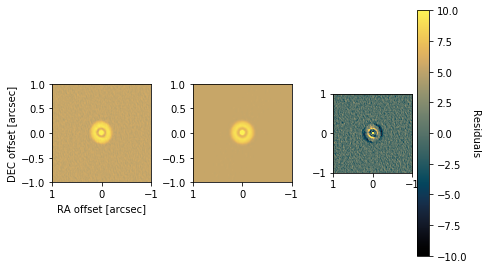

In [51]:
# your code here
import os, sys, time           # I basically always load these in every code I write.
import numpy as np             # Numpy is the basic numerics package in Python.
from astropy.io import fits    # .FITS file manipulation package  
import urllib.request          # package for fetching files off the internet
import matplotlib.pyplot as plt    # plotting package
from matplotlib.patches import Ellipse    # plotting package
import cmasher as cmr          # color maps
from astropy.visualization import (AsinhStretch, LogStretch, SqrtStretch, ImageNormalize, LinearStretch)


diskname='SR4'
datadata=fits.open('SR4_data.fits')
datared=fits.open('SR4_resid.fits')
datamod=fits.open('SR4_model.fits')

datadata1=np.squeeze(datadata[0].data)
datared1=np.squeeze(datared[0].data)
datamod1=np.squeeze(datamod[0].data)
header1=datadata[0].header
header2=datared[0].header
header3=datamod[0].header


def my_function(x):
    class my_class:
        def __init__(self,image, dRA, dDEC):
            self.image = image
            self.dRA = dRA
            self.dDEC = dDEC
    image = np.squeeze(x[0].data)
    header = x[0].header
    nx, ny = header['NAXIS1'], header['NAXIS2']
    RA = header['CRVAL1'] + header['CDELT1'] * (np.arange(nx) - (header['CRPIX1'] - 1))
    DEC = header['CRVAL2'] + header['CDELT2'] * (np.arange(ny) - (header['CRPIX2'] - 1))
    RAo, DECo = 3600 * (RA - header['CRVAL1']), 3600 * (DEC - header['CRVAL2'])
    offRA, offDEC = -0.0636, -0.5090    # measured in Huang et al. 2018, ApJL, 869, L42
    RAo_shift, DECo_shift = RAo - offRA, DECo - offDEC
    dRA, dDEC = np.meshgrid(RAo_shift, DECo_shift)
    # create an object
    my_object = my_class(image, dRA, dDEC)
    
    return my_object
SR4mod=my_function(datamod)
SR4data=my_function(datadata)
SR4red=my_function(datared)

def diskplotter(x,y,z):
    im_bounds = (x.dRA.max(), x.dRA.min(), x.dDEC.min(), x.dDEC.max())
    dRA_lims  = [1, -1]      # (same reverse ordering to ensure E is to the left)
    dDEC_lims = [-1, 1]
    cmap = cmr.eclipse
    vmin, vmax = -1, 1    # these are in mJy/beam units
    norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=LinearStretch())
    norm2 = ImageNormalize(vmin=-10, vmax=10)
    fig, (ax1,ax2, ax3) = plt.subplots(1,3)
    fig.tight_layout()
    im = ax1.imshow(1e3*x.image, origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
    ax1.set_xlim(dRA_lims)
    ax1.set_ylim(dDEC_lims)
    ax1.set_xlabel('RA offset [arcsec]')
    ax1.set_ylabel('DEC offset [arcsec]')
    
    
    im2 = ax2.imshow(1e3*y.image, origin='lower', cmap=cmap, extent=im_bounds,norm=norm, aspect='equal')
    ax2.set_xlim(dRA_lims)
    ax2.set_ylim(dDEC_lims)
    
    

    
    im3 = ax3.imshow(1e6*z.image/25, origin='lower', cmap=cmap, extent=im_bounds,norm=norm2, aspect='equal')
    ax3.set_xlim(dRA_lims)
    ax3.set_ylim(dDEC_lims)
   
    cb3 = plt.colorbar(im3, ax=ax3, pad=0.05)
    cb3.set_label('Residuals', rotation=270, labelpad=13)

diskplotter(SR4data, SR4mod, SR4red)



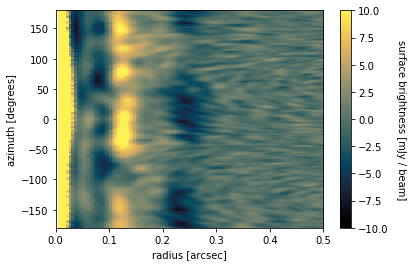

In [48]:
from scipy.interpolate import interp1d
incl, PA = 24.2, 43.7   # these were measured by the DSHARP consortium (Huang et al. 2018, ApJL, 869, L42 - Table 2)


inclr, PAr = np.radians(incl), np.radians(PA)

xp = (SR4red.dRA * np.cos(PAr) - SR4red.dDEC * np.sin(PAr)) / np.cos(inclr)
yp = (SR4red.dRA * np.sin(PAr) + SR4red.dDEC * np.cos(PAr))


r = np.sqrt(xp**2 + yp**2)
theta = np.degrees(np.arctan2(yp, xp))
rbins = np.linspace(0.005, 1.5, 300)    # in arcseconds
tbins = np.linspace(-180, 180, 181)     # in degrees
dr = np.abs(rbins[1] - rbins[0])
dt = np.abs(tbins[1] - tbins[0])

rtmap = np.empty((len(tbins), len(rbins)))
SBr, err_SBr = np.empty(len(rbins)), np.empty(len(rbins))

for i in range(len(rbins)):
    in_annulus = ((r >= (rbins[i] - 0.5 * dr)) & (r < (rbins[i] + 0.5 * dr)))
    az_annulus = theta[in_annulus]
    SB_annulus = SR4red.image[in_annulus]
    
    SBr[i], err_SBr[i] = np.average(SB_annulus), np.std(SB_annulus)
    for j in range(len(tbins)):
        in_wedge = ((az_annulus >= (tbins[j] - 0.5 * dt)) & (az_annulus < (tbins[j] + 0.5 * dt)))
        if (len(SB_annulus[in_wedge]) > 0):
            rtmap[j,i] = np.average(SB_annulus[in_wedge])
        else:
            rtmap[j,i] = -1e10   
            
for i in range(len(rbins)):
    az_slice = rtmap[:,i]
    if np.any(az_slice < -1e5):
        x_slice, y_slice = tbins[az_slice >= -1e5], az_slice[az_slice >= -1e5]
        x_slice_ext = np.pad(x_slice, 1, mode='wrap')
        x_slice_ext[0] -= 360.
        x_slice_ext[-1] += 360.
        y_slice_ext = np.pad(y_slice, 1, mode='wrap')
        raz_func = interp1d(x_slice_ext, y_slice_ext, bounds_error=True)
        fixed_slice = raz_func(tbins)
        rtmap[:,i] = fixed_slice
    
rtmap_bounds = (rbins.min(), rbins.max(), tbins.min(), tbins.max())


t_lims = [-180, 180]      
r_lims = [0, 0.5]

cmap = cmr.eclipse
vmin, vmax = -10, 10    # these are in mJy/beam units
norm3 = ImageNormalize(vmin=vmin, vmax=vmax)

# set up and plot the image on the specified scale
fig, ax = plt.subplots()
im = ax.imshow(1e6*rtmap/25, origin='lower', cmap=cmap, extent=rtmap_bounds, norm=norm3, aspect='auto')
ax.set_xlim(r_lims)
ax.set_ylim(t_lims)
ax.set_ylabel('azimuth [degrees]')
ax.set_xlabel('radius [arcsec]')


cb = plt.colorbar(im, ax=ax, pad=0.05)
cb.set_label('surface brightness [mJy / beam]', rotation=270, labelpad=17)            

C:\Users\William\anaconda3\lib\site-packages\numpy\lib\function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\William\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'Residuals [Jy / arcsec$^2$]')

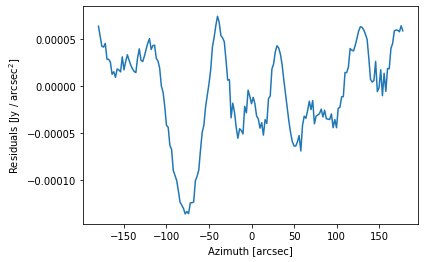

In [80]:
rbins = np.linspace(0.005, 1.5, 300)    # in arcseconds
tbins = np.linspace(-180, 180, 181)     # in degrees
dr = np.abs(rbins[1] - rbins[0])
dt = np.abs(tbins[1] - tbins[0])

# initialize the (r, az)-map and radial profile
rtmap = np.empty((len(tbins), len(rbins)))
SBr_r, err_SBr = np.empty(len(tbins)), np.empty(len(tbins))

for i in range(len(tbins)):
        # identify pixels that correspond to the radial bin (i.e., in this annulus)
        in_wedge = (theta >= (tbins[i] - 0.5 * dt)) & (theta< (tbins[i] + 0.5 * dt))&(r>=0.09)&(r<0.1)

        SB_f = SR4red.image[in_wedge]
        

        
        SBr_r[i], err_SBr[i] = (np.average(SB_f), np.std(SB_annulus))
                                        

fig, ax = plt.subplots()

# the profile on a linear scaling
ax.plot(tbins, SBr_r)
ax.set_xlabel('Azimuth [arcsec]')
ax.set_ylabel('Residuals [Jy / arcsec$^2$]')            
                      
                            
                            

Text(0, 0.5, 'Residuals [Jy / arcsec$^2$]')

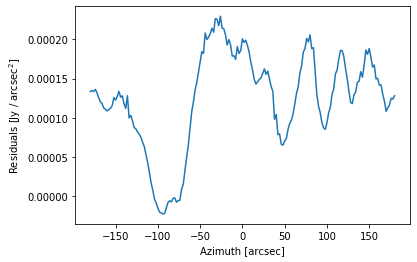